In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # Visualization
import seaborn as sns #Visualization
plt.rcParams['figure.figsize'] = [8,5]
plt.rcParams['font.size'] =14
plt.rcParams['font.weight']= 'bold'
import scipy 
from scipy import stats 
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import math


#https://www.kaggle.com/code/sudhirnl7/linear-regression-tutorial

Read in dataset

In [7]:
df = pd.read_csv("Prostate.txt", delimiter='\t', index_col=0)
df

# Predictors (columns 1--8)

# lcavol
# lweight
# age
# lbph
# svi
# lcp
# gleason
# pgg45

# outcome (column 9)

# lpsa

# train/test indicator (column 10)

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
1,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,T
2,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,T
3,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,T
4,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,T
5,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,T
...,...,...,...,...,...,...,...,...,...,...
93,2.830268,3.876396,68,-1.386294,1,1.321756,7,60,4.385147,T
94,3.821004,3.896909,44,-1.386294,1,2.169054,7,40,4.684443,T
95,2.907447,3.396185,52,-1.386294,1,2.463853,7,10,5.143124,F
96,2.882564,3.773910,68,1.558145,1,1.558145,7,80,5.477509,T


Data Quality Check

<class 'pandas.core.frame.DataFrame'>
Index: 97 entries, 1 to 97
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   lcavol   97 non-null     float64
 1   lweight  97 non-null     float64
 2   age      97 non-null     int64  
 3   lbph     97 non-null     float64
 4   svi      97 non-null     int64  
 5   lcp      97 non-null     float64
 6   gleason  97 non-null     int64  
 7   pgg45    97 non-null     int64  
 8   lpsa     97 non-null     float64
 9   train    97 non-null     object 
dtypes: float64(5), int64(4), object(1)
memory usage: 8.3+ KB


C:\Users\levor\AppData\Local\Temp\ipykernel_9796\2217936697.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['lpsa'],bins=50,color='r',ax=ax)
c:\Users\levor\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\levor\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\levor\AppData\Local\Temp\ipykernel_9796\2217936

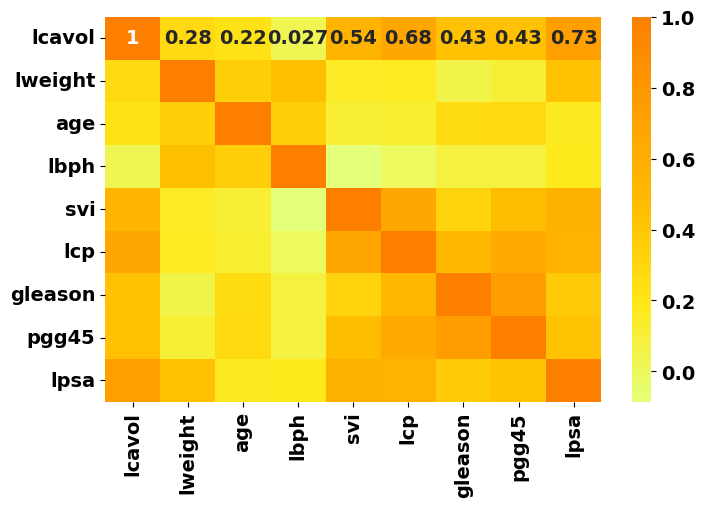

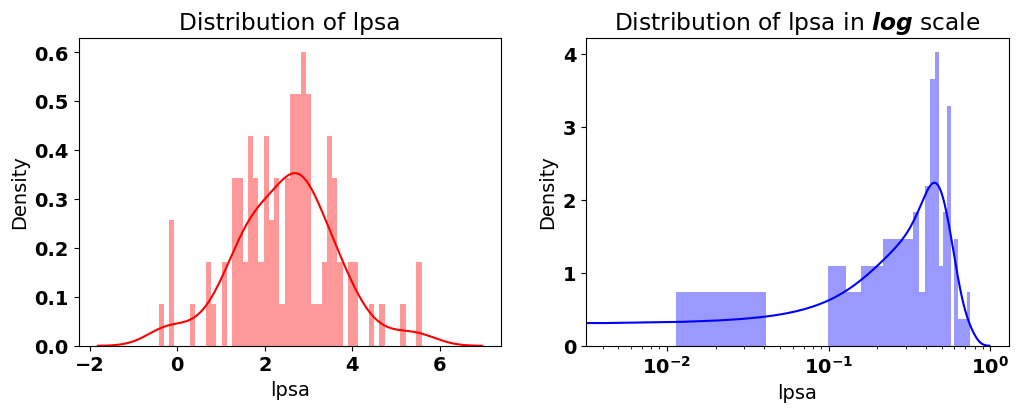

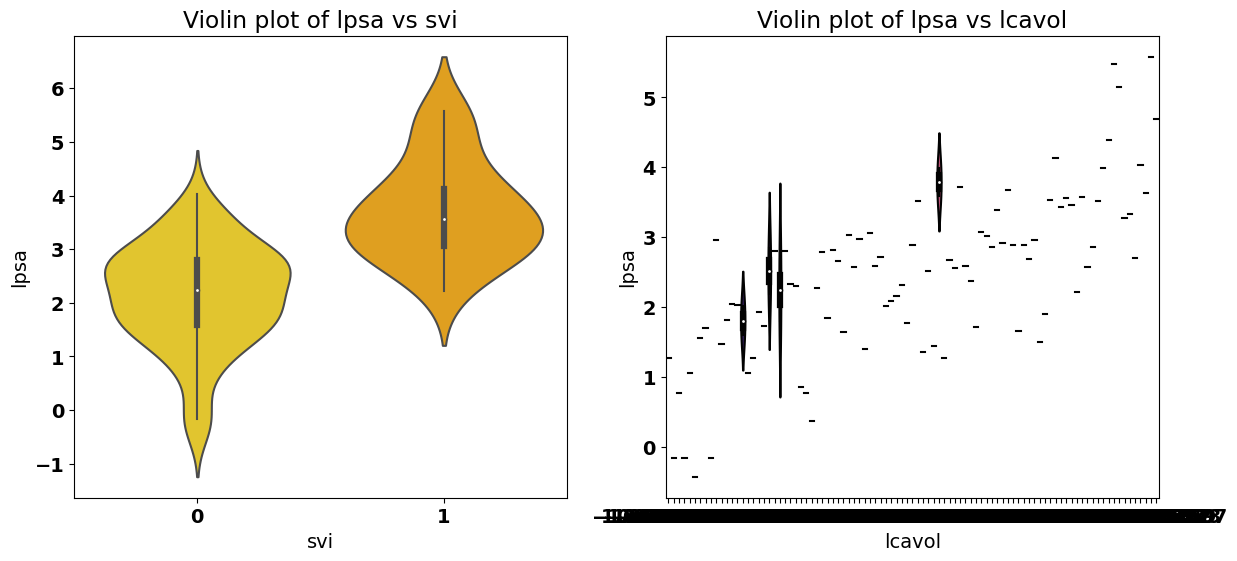

In [13]:
# Overall
df.info()
df.describe()
# correlation plot
ds = df.drop(columns=['train'], axis=1)

# Correlation
corr = ds.corr()
sns.heatmap(corr, cmap = 'Wistia', annot= True);

# Distribution of target variable

f= plt.figure(figsize=(12,4))

ax=f.add_subplot(121)
sns.distplot(df['lpsa'],bins=50,color='r',ax=ax)
ax.set_title('Distribution of lpsa')

ax=f.add_subplot(122)
sns.distplot(np.log10(df['lpsa']),bins=40,color='b',ax=ax)
ax.set_title('Distribution of lpsa in $log$ scale')
ax.set_xscale('log');


# Violin plot of lpsa vs. lcavol  and lpsa vs. svi
f = plt.figure(figsize=(14,6))
ax = f.add_subplot(121)
sns.violinplot(x='svi', y='lpsa',data=df,palette='Wistia',ax=ax)
ax.set_title('Violin plot of lpsa vs svi')

ax = f.add_subplot(122)
sns.violinplot(x='lcavol', y='lpsa',data=df,palette='magma',ax=ax)
ax.set_title('Violin plot of lpsa vs lcavol');


Data preparation

In [72]:
# No need to do any dummy variable transformation
# No need to log transform the target variable

# We split the sample into Train (train = T) and Test (train = F)

trainSample = df.loc[df['train'] == "T"]
testSample = df.loc[df['train'] == "F"]

# Prepare Train Sample
X_Train = trainSample.drop(columns = ['lpsa','train'], axis=1)

if True:
    cols = X_Train.columns

    for i in range(len(cols)):
        # Z-Score using scipy 
        X_Train[cols[i]] = stats.zscore(X_Train[cols[i]]) 

Y_Train= trainSample['lpsa'].values

# Prepare Test Sample
X_Test = testSample.drop(columns = ['lpsa','train'], axis=1)

if True:
    cols = X_Test.columns

    for i in range(len(cols)):
        # Z-Score using scipy 
        X_Test[cols[i]] = stats.zscore(X_Test[cols[i]]) 

Y_Test= testSample['lpsa'].values

In [71]:
#Train Model and produce results
X_Train = sm.add_constant(X_Train, prepend=False)

model = sm.OLS(Y_Train,X_Train)
result = model.fit()
result.summary()

# Coefficient / Std Error = Z-Score
###########################################################################################

,Parameter,Columns,theta,Sklearn_theta
0,theta_0,intersect:x_0=1,2.452345,2.452345
1,theta_1,lcavol,0.711041,0.711041
2,theta_2,lweight,0.290450,0.290450
3,theta_3,age,-0.141482,-0.141482
4,theta_4,lbph,0.210420,0.210420
5,theta_5,svi,0.307300,0.307300
6,theta_6,lcp,-0.286841,-0.286841
7,theta_7,gleason,-0.020757,-0.020757
8,theta_8,pgg45,0.275268,0.275268
